In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
import torch
from torch import nn

from hparams.light56_hparams import create_hparams
from model import Model
from datasets import LJDataset, TextMelCollate
from utils import sizeof_fmt, Logger

In [2]:
!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Thu Mar 11 03:49:31 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:2E:00.0 Off |                  N/A |
| 53%   63C    P0    73W / 250W |      0MiB / 11016MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:2F:00.0 Off |                  N/A |
| 47%   

In [ ]:
from parallel_wavegan.utils import download_pretrained_model
from parallel_wavegan.utils import load_model

device='cuda'
vocoder_tag = "ljspeech_parallel_wavegan.v1"

# NOTE: Sometimes download is failed due to "Permission denied". That is 
#   the limitation of google drive. Please retry after serveral hours.
vocoder = load_model(download_pretrained_model(vocoder_tag)).to(device).eval()
vocoder.remove_weight_norm()
print('done')

from parallel_wavegan.utils import read_hdf5

stats_filename = "/home/rubato/.cache/parallel_wavegan/ljspeech_parallel_wavegan.v1/stats.h5"
mean = read_hdf5(stats_filename, 'mean')
scale = read_hdf5(stats_filename, 'scale')
print('done')

In [3]:
save_dir = 'save/light56_model'
logger = Logger(save_dir=save_dir, new=False)
print('done')

done


In [4]:
!ls $save_dir

data.json   save_33049	save_35625  save_36975
save_32509  save_35000	save_36974


In [5]:
stt_hparams, tts_hparams = create_hparams()
model = Model(stt_hparams, tts_hparams)
model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=tts_hparams.lr, weight_decay=tts_hparams.weight_decay)

step = 36975

size = sizeof_fmt(4 * sum(p.numel() for p in model.parameters()))
print(f"Model size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.parameters()))
print(f"TTS size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_encoder.parameters()))
print(f"MelEncoder size {size}")

size = sizeof_fmt(4 * sum(p.numel() for p in model.tts.mel_decoder.parameters()))
print(f"MelDecoder size {size}")

if True:
    model, optimizer, step = logger.load(step, model, optimizer)
print(step)

print('done')

Model size 243.8MiB
TTS size 156.2MiB
MelEncoder size 52.3MiB
MelDecoder size 94.9MiB
loaded : 36975
36975
done


In [6]:
trainset = LJDataset(tts_hparams)
collate_fn = TextMelCollate(tts_hparams)
train_loader = torch.utils.data.DataLoader(trainset, num_workers=8, #tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(train_loader)

validset = LJDataset(tts_hparams, split='valid')
valid_loader = torch.utils.data.DataLoader(validset, num_workers=tts_hparams.num_workers, 
                          shuffle=True, sampler=None, batch_size=tts_hparams.batch_size, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(valid_loader)

testset = LJDataset(tts_hparams, split='test')
test_loader = torch.utils.data.DataLoader(testset, num_workers=1, 
                          shuffle=False, sampler=None, batch_size=1, pin_memory=False,
                          drop_last=True, collate_fn=collate_fn)
print(test_loader)

In [7]:
import time

t0 = time.time()
for i, batch in enumerate(train_loader):
    t1 = time.time()
    print(t1 - t0)
    t0 = time.time()
    if i > 10:
        break


1.2939705848693848
0.045968055725097656
0.0009036064147949219
0.13455772399902344
0.0009112358093261719
0.0008754730224609375
0.0009295940399169922
0.04585385322570801
0.6419739723205566
0.25756382942199707
0.0008661746978759766
0.0008985996246337891


In [8]:
def to_cuda(batch):
    batch['text'] = batch['text'].cuda()
    batch['text_lengths'] = batch['text_lengths'].cuda()
    batch['mels'] = batch['mels'].cuda()
    batch['mel_lengths'] = batch['mel_lengths'].cuda()
    
    return batch

elapsed time : 0.047960734367370604


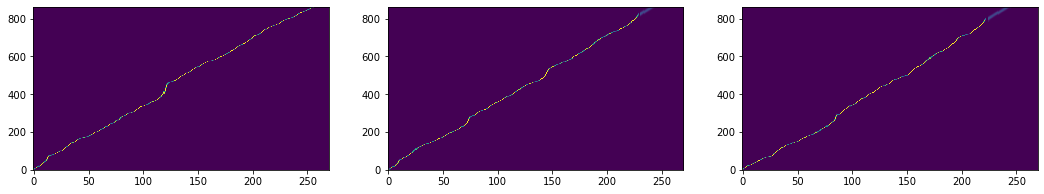

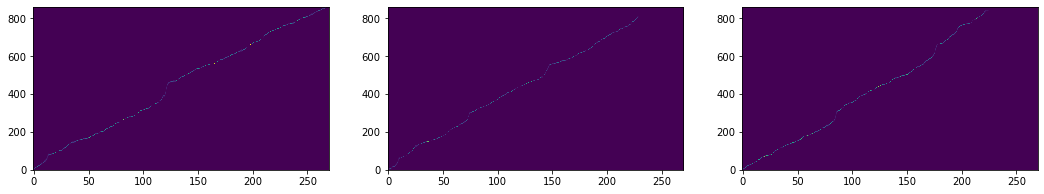

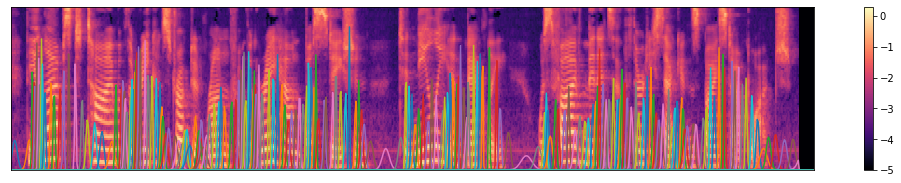

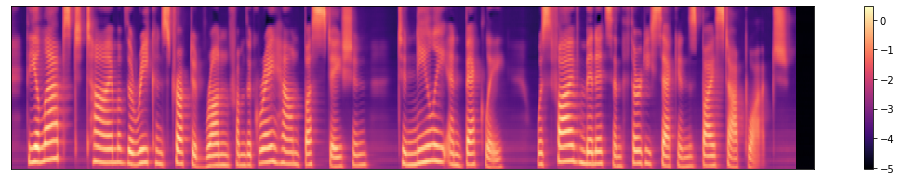

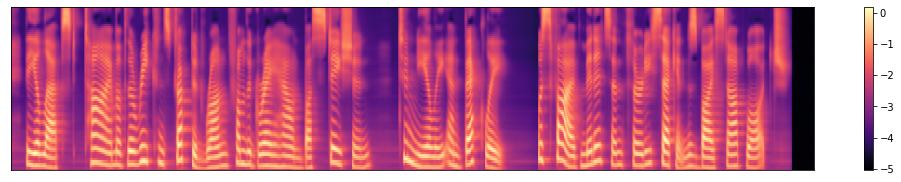

tensor(0.1643, device='cuda:0')
step : 53001 stt : 0.0005 tts : 0.1156 recon : 0.0251 kl : 0.0089 beta : 1.0000
tensor(0.1560, device='cuda:0')
step : 53002 stt : 0.0016 tts : 0.1434 recon : 0.0301 kl : 0.0103 beta : 1.0000
tensor(0.2733, device='cuda:0')
step : 53003 stt : 0.0019 tts : 0.1339 recon : 0.0291 kl : 0.0099 beta : 1.0000
tensor(0.1996, device='cuda:0')
step : 53004 stt : 0.0024 tts : 0.1375 recon : 0.0310 kl : 0.0104 beta : 1.0000
tensor(0.1611, device='cuda:0')
step : 53005 stt : 0.0017 tts : 0.1306 recon : 0.0273 kl : 0.0094 beta : 1.0000
tensor(0.1578, device='cuda:0')
step : 53006 stt : 0.0014 tts : 0.1232 recon : 0.0275 kl : 0.0094 beta : 1.0000
tensor(0.1905, device='cuda:0')
step : 53007 stt : 0.0023 tts : 0.1386 recon : 0.0282 kl : 0.0098 beta : 1.0000
tensor(0.2058, device='cuda:0')
step : 53008 stt : 0.0020 tts : 0.1231 recon : 0.0270 kl : 0.0094 beta : 1.0000
tensor(0.2038, device='cuda:0')
step : 53009 stt : 0.0015 tts : 0.1209 recon : 0.0290 kl : 0.0097 beta :

tensor(0.2077, device='cuda:0')
step : 53075 stt : 0.0019 tts : 0.1210 recon : 0.0293 kl : 0.0098 beta : 1.0000
tensor(0.2655, device='cuda:0')
step : 53076 stt : 0.0014 tts : 0.1336 recon : 0.0277 kl : 0.0095 beta : 1.0000
tensor(0.1947, device='cuda:0')
step : 53077 stt : 0.0015 tts : 0.1471 recon : 0.0293 kl : 0.0102 beta : 1.0000
tensor(0.1632, device='cuda:0')
step : 53078 stt : 0.0023 tts : 0.1227 recon : 0.0281 kl : 0.0097 beta : 1.0000
tensor(0.2192, device='cuda:0')
step : 53079 stt : 0.0016 tts : 0.1190 recon : 0.0262 kl : 0.0092 beta : 1.0000
tensor(0.1847, device='cuda:0')
step : 53080 stt : 0.0012 tts : 0.1328 recon : 0.0295 kl : 0.0103 beta : 1.0000
tensor(0.2012, device='cuda:0')
step : 53081 stt : 0.0027 tts : 0.1328 recon : 0.0302 kl : 0.0102 beta : 1.0000
tensor(0.2722, device='cuda:0')
step : 53082 stt : 0.0020 tts : 0.1231 recon : 0.0276 kl : 0.0095 beta : 1.0000
tensor(0.2536, device='cuda:0')
step : 53083 stt : 0.0020 tts : 0.1144 recon : 0.0264 kl : 0.0094 beta :

KeyboardInterrupt: 

In [57]:
from IPython import display
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time

model.train()

while(True):
    
    for batch in train_loader:
        batch = to_cuda(batch)
        
        model.train()
        model.increase_step()
        model.zero_grad()

        stt_outputs, tts_outputs = model(batch)
        loss = tts_outputs['loss'] + stt_outputs['loss']
        loss.backward()
        
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), 1)
        print(grad_norm.mean())
        if torch.isnan(grad_norm.mean()):
            continue
        
        optimizer.step()
        
        if step % 5000 == 0:
            logger.save(step, model, optimizer)
        
        if step % 1 == 0:
            print('step :', step, 
                  'stt :', '%0.4f' % stt_outputs['loss'].item(),
                  'tts :', '%0.4f' % tts_outputs['loss'].item(),
                  'recon :', '%0.4f' % tts_outputs['recon_loss'].item(),
                  'kl :', '%0.4f' % tts_outputs['kl_loss'].item(),
                  'beta :', '%0.4f' % model.beta)
                  
            
        if step % 100 == 0:
            logger.log(step, 'stt_loss', stt_outputs['loss'].item())
            logger.log(step, 'tts_loss', tts_outputs['loss'].item())    
            logger.log(step, 'recon_loss', tts_outputs['recon_loss'].item())    
            logger.log(step, 'kl_loss', tts_outputs['kl_loss'].item())    
            logger.log(step, 'beta', model.beta)    
            
        if step % 100 == 0:
            display.clear_output()
            
            index = 3
            model.eval()
            
            with torch.no_grad():
                times = []
                for _ in range(10):
                    t0 = time.time()
                    samples, _ = model.inference(batch['text'], batch['mels'].size(2), stt_outputs["alignments"], temperature=1.0)
                    t1 = time.time()
                    times.append(t1 - t0)
                times = np.array(times)
                print('elapsed time :', np.mean(times))

            _tts_alignments = tts_outputs["alignments"].data.cpu().numpy()
            batch_size = _tts_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_tts_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            _stt_alignments = stt_outputs["alignments"].data.cpu().numpy()
            batch_size = _stt_alignments.shape[0]
            plt.figure(figsize=[18, 3])
            for i in range(3):
                plt.subplot(1, 3, i+1)
                plt.imshow(_stt_alignments[i].T, aspect='auto', origin='lower', interpolation='none')
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _x = batch['mels'].data.cpu().numpy()
            librosa.display.specshow(_x[index])
            plt.colorbar()
            
            for i in range(_stt_alignments.shape[1]):
                plt.plot(_stt_alignments[index, i] * 100)
                
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _y = tts_outputs['pred'].data.cpu().numpy()
            librosa.display.specshow(_y[index])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 3])
            _s = samples.data.cpu().numpy()
            librosa.display.specshow(_s[index, :, :_y.shape[2]])
            plt.colorbar()
            plt.show()
                      
        step += 1
        

In [58]:
logger.save(step, model, optimizer)

saved save/light56_model/save_53086


hundreds of women and children came in every morning to spend the day there, and there was no limitation whatever to the numbers of visitors admitted to the debtors' side.
torch.Size([1, 80, 864]) 0.011853647232055665
{'alignment': 0.00045371055603027344, 'random': 0.00014066696166992188, 'last_conv': 0.003529071807861328, 'z_proj': 0.00015020370483398438, 'cond': 0.0006339550018310547, 'up': 0.0002560615539550781, 'encode': 0.005581378936767578, 'pad': 3.337860107421875e-05, 'enc_conv': 0.0007154941558837891, 'enc_lstm': 0.004668712615966797}


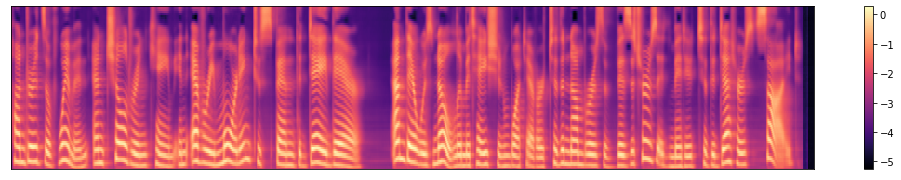

In [71]:
import matplotlib.pyplot as plt
import librosa.display
import numpy as np
import time 

for i, batch in enumerate(test_loader):
    batch = to_cuda(batch)
    if i == 6:
        break
print(batch['strings'][0])

model.eval()
with torch.no_grad():
    index = 0
    times = []
    for _ in range(10):
        t0 = time.time()
        samples, time_dict = model.inference(batch['text'][0:1], None, None, temperature=1.0)
        t1 = time.time()
        times.append(t1 - t0)
    times = np.array(times)
    print(samples.shape, np.mean(times))
    print(time_dict)
    
    plt.figure(figsize=[18, 3])
    _x = batch['mels'].data.cpu().numpy()
    _s = samples.data.cpu().numpy()
    librosa.display.specshow(_s[index])
    plt.colorbar()
    plt.show()

In [72]:
vocoder.eval()
with torch.no_grad():
    _mel = _s[0].T
    _mel = (_mel - mean) / scale
    mel = torch.from_numpy(_mel).cuda()
    wav = vocoder.inference(mel)
    _wav = wav[:, 0].data.cpu().numpy()
    print(_wav.shape)
    
import IPython.display as ipd
ipd.Audio(_wav, rate=22050)

(221184,)
